In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/carvana-image-masking-challenge/train_masks.zip
/kaggle/input/carvana-image-masking-challenge/29bb3ece3180_11.jpg
/kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip
/kaggle/input/carvana-image-masking-challenge/train.zip
/kaggle/input/carvana-image-masking-challenge/metadata.csv.zip
/kaggle/input/carvana-image-masking-challenge/sample_submission.csv.zip
/kaggle/input/carvana-image-masking-challenge/test.zip
/kaggle/input/carvana-image-masking-challenge/test_hq.zip
/kaggle/input/carvana-image-masking-challenge/train_hq.zip


In [2]:
import glob
import zipfile
from PIL import Image

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.transforms import ToTensor, CenterCrop
from torch.utils.data import Dataset, DataLoader

In [3]:
input_dir = "/kaggle/input/carvana-image-masking-challenge/"
output_dir = "/kaggle/working/"

In [4]:
with zipfile.ZipFile(input_dir+"train.zip", 'r') as zip_ref:
    zip_ref.extractall(output_dir)
    
with zipfile.ZipFile(input_dir+"train_masks.zip", 'r') as zip_ref:
    zip_ref.extractall(output_dir)
    
with zipfile.ZipFile(input_dir+"sample_submission.csv.zip", 'r') as zip_ref:
    zip_ref.extractall(output_dir)

In [5]:
train_val_images = glob.glob(output_dir+"train/*")

train_val_images = sorted(train_val_images)

train_val_images = [s.split("/")[-1].split(".")[0] for s in train_val_images]

len(train_val_images)

5088

In [6]:
train_images, val_images = train_test_split(train_val_images, test_size=0.1, random_state=42)

In [7]:
train_images[0], val_images[0]

('69915dab0755_11', '1ba84b81628e_14')

In [8]:
len(train_images),len(val_images)

(4579, 509)

In [9]:
img_size = 576
mask_size = 388

class CustomImageDataset(Dataset):
    def __init__(self, img_ids, transform=None):
        self.img_ids = img_ids
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_path = "/kaggle/working/train/" + img_id + ".jpg"
        mask_path = "/kaggle/working/train_masks/" + img_id + "_mask.gif"
        image = Image.open(img_path)
        image = image.resize((img_size, img_size))
        mask = Image.open(mask_path).convert("L")
        mask = mask.resize((mask_size, mask_size))
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

In [10]:
training_data = CustomImageDataset(train_images, ToTensor())
val_data = CustomImageDataset(val_images, ToTensor())

In [11]:
for x, y in training_data:
    print(x.shape)
    print(y.shape)
    break

torch.Size([3, 576, 576])
torch.Size([1, 388, 388])


In [12]:
train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=4, shuffle=True)

In [13]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [14]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
        
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.conv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3)
        
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3)
        self.conv10 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3)
        
        self.upconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=1024, kernel_size=2, stride=2)
        
        self.conv11 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3)
        
        self.upconv2 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2)
        
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3)
        self.conv14 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
        
        self.upconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)
        
        self.conv15 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3)
        self.conv16 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
        
        self.upconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)
        
        self.conv17 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3)
        self.conv18 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        
        self.finalconv = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        crop392 = CenterCrop((392, 392))(x)
        
        x = F.relu(self.pool(x))
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        crop200 = CenterCrop((200, 200))(x)
        
        x = F.relu(self.pool(x))
        
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        
        crop104 = CenterCrop((104, 104))(x)
        
        x = F.relu(self.pool(x))
        
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        
        crop56 = CenterCrop((56, 56))(x)
        
        x = F.relu(self.pool(x))
        
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        
        x = F.relu(self.upconv1(x) + torch.cat((crop56, crop56), 1))
        
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        
        x = F.relu(self.upconv2(x) + torch.cat((crop104, crop104), 1))

        x = F.relu(self.conv13(x))
        x = F.relu(self.conv14(x))
        
        x = F.relu(self.upconv3(x) + torch.cat((crop200, crop200), 1))

        x = F.relu(self.conv15(x))
        x = F.relu(self.conv16(x))

        x = F.relu(self.upconv4(x) + torch.cat((crop392, crop392), 1))

        x = F.relu(self.conv17(x))
        x = F.relu(self.conv18(x))

        x = self.finalconv(x)

        return x

        
model = UNet().to(device)
print(model)

UNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv9): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (conv10): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1))
  (upconv1): ConvTranspose2d(1024, 1024, kernel_size=(2, 2), stride=(2, 2))
  (conv11): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (upconv2): ConvTranspose2d(512, 512, kernel_size=(2, 2), stride=(2, 2))
  (conv13): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv14): Conv2d(256,

In [15]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

In [16]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [17]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 0.669534  [    4/ 4579]
loss: 0.538827  [  404/ 4579]
loss: 0.454460  [  804/ 4579]
loss: 0.487210  [ 1204/ 4579]
loss: 0.493959  [ 1604/ 4579]
loss: 0.423494  [ 2004/ 4579]
loss: 0.416336  [ 2404/ 4579]
loss: 0.200269  [ 2804/ 4579]
loss: 0.232132  [ 3204/ 4579]
loss: 0.160451  [ 3604/ 4579]
loss: 0.139009  [ 4004/ 4579]
loss: 0.090683  [ 4404/ 4579]
Epoch 2
-------------------------------
loss: 0.154481  [    4/ 4579]
loss: 0.094545  [  404/ 4579]
loss: 0.171211  [  804/ 4579]
loss: 0.093861  [ 1204/ 4579]
loss: 0.109574  [ 1604/ 4579]
loss: 0.137193  [ 2004/ 4579]
loss: 0.083157  [ 2404/ 4579]
loss: 0.088619  [ 2804/ 4579]
loss: 0.070040  [ 3204/ 4579]
loss: 0.099289  [ 3604/ 4579]
loss: 0.083880  [ 4004/ 4579]
loss: 0.090402  [ 4404/ 4579]
Done!


In [18]:
def plot_images(images, mask = False):
    fig = plt.figure(figsize=(10, 8))
    columns = len(images)
    rows = 1
    for i in range(columns*rows):
        img = images[i]
        fig.add_subplot(rows, columns, i+1)
        if mask:
            img = img > 0.5
        plt.imshow(img, cmap="gray")
    plt.show()

In [19]:
def visualize_result(dataloader):
    tr_imgs = []
    msk_imgs = []
    
    for x, y in dataloader:
        x = x.to(device)
        
        pred = model(x)
        
        for i in range(x.shape[0]):
            tr_img = x[i].cpu().detach().numpy()
            tr_img = np.einsum('kij->ijk',tr_img)
            tr_imgs.append(tr_img)
            
            msk_img = pred[i].cpu().detach().numpy()
            msk_img = msk_img.reshape((mask_size, mask_size))
            msk_imgs.append(msk_img)

        break
        
    plot_images(tr_imgs, mask=False)
    plot_images(msk_imgs, mask=True)

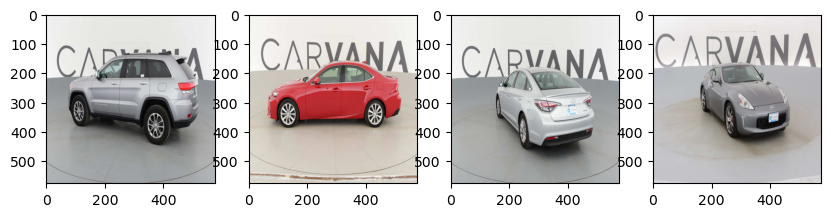

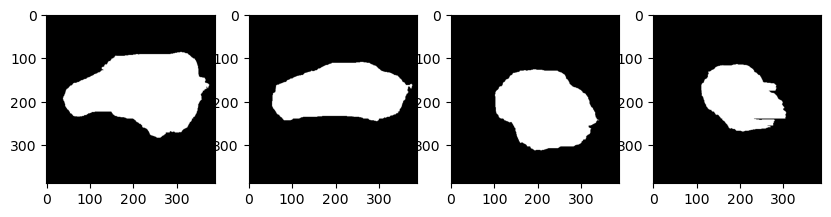

In [20]:
visualize_result(val_dataloader)